# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc, get_sqrt_diag_cov_from_numpyro

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu02.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
# m, ev, lo, rsdb, pc, samp, mm
task_id = 2111230
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)
print("save path:", save_path)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)
# print("jax_enable_x64:", jconfig.read("jax_enable_x64"))

SLURM_ARRAY_TASK_ID: 2111230
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sMCLMC_nc4_ns64_nomm


# CONFIG
{'a_obs': 0.5,
 'box_shape': array([160., 160., 160.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.06},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
   

no bias


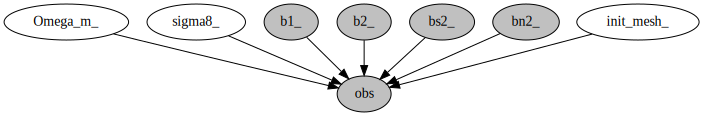

In [3]:
print(model)
print(mcmc_config)
# model.render()
# model.prior_mode = 'prior' ###############

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    if model.loc_fid['b1'] == 0:
        truth['b1'] = 0.

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir+"model.p")    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()
model.render()

## Run

### NUTS, HMC

# Loading init_last_state
dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])
MSEs: [4.29059106 4.31118426 4.29816904 4.33823995] [4.29059106 4.31118426 4.29816904 4.33823995]
no bias
dict_keys(['Omega_m_', 'sigma8_', 'init_mesh_'])
{'Omega_m_': Array([1., 1., 1., 1.], dtype=float64), 'sigma8_': Array([1., 1., 1., 1.], dtype=float64), 'init_mesh_': Array([[[[1.05577234, 0.78862748, 1.02284209, ..., 1.00798959,
          0.90702868, 1.07464231],
         [0.82689448, 0.74798706, 0.82271953, ..., 1.0951692 ,
          1.06101079, 0.94044179],
         [0.89103609, 0.97720844, 0.92455164, ..., 1.2177895 ,
          0.97022496, 1.23183718],
         ...,
         [0.92405888, 1.00429817, 0.93495739, ..., 0.96809277,
          1.11123051, 1.04911127],
         [0.99269759, 0.6870307 , 0.90083454, ..., 1.27684393,
          1.03581417, 1.23981452],
         [0.90143917, 0.87666977, 0.95894779, ..., 1.17841115,
          1.02761476, 1.14006

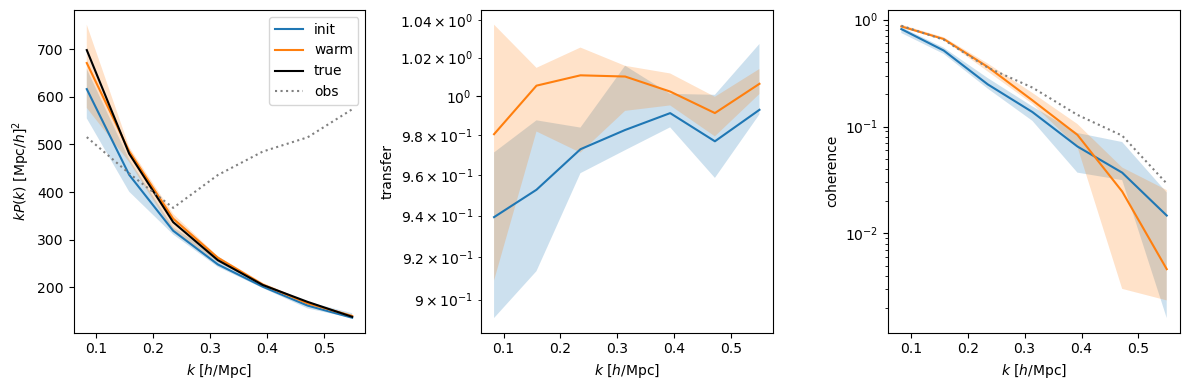

In [4]:
continue_run = False
if continue_run:
    pass
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
    model.block()

    mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    init_params_ = jit(vmap(partial(model.init_model, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), mcmc.num_chains))
    # init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)
    
    if not os.path.exists(save_path + "_init_last_state.p"):
        print("# Warmupping...")
        init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
        mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
        ils = mcmc.last_state.z
    else:
        print("# Loading init_last_state")
        ils = pload(save_path + "_init_last_state.p").z
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

    ################
    from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    kpk0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    kpkobs = model.spectrum(truth['obs']-1)
    
    print(ils.keys(), init_params_.keys())

    mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    print("MSEs:", mse_, mse_)

    prob = 0.95
    plt.figure(figsize=(12, 4))
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    plot_powtranscoh(*kptcs__, fill=prob)
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    plot_powtranscoh(*kptcs_, fill=prob)
    plt.subplot(131)
    plot_pow(*kpk0, 'k', label='true')
    plot_pow(*kpkobs, ':', c='grey', label='obs')
    plt.legend()
    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    plt.tight_layout()
    plt.savefig(save_dir+f'init_glin_{task_id}.png')
    # plt.savefig(f'init_glin_{task_id}.png')
    ################    
    
    if model.loc_fid['b1'] == 0:
        print('no bias')
        init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_']} | ils
        # init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_','b1_','b2_','bs2_']} | ils
    else:
        init_params_ |= ils
        # init_params_ |= mcmc.last_state.z
    print(init_params_.keys())

    sqrt_diag_cov = get_sqrt_diag_cov_from_numpyro(pload(save_path + "_init_last_state.p"), init_params_)
    print(sqrt_diag_cov)

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()

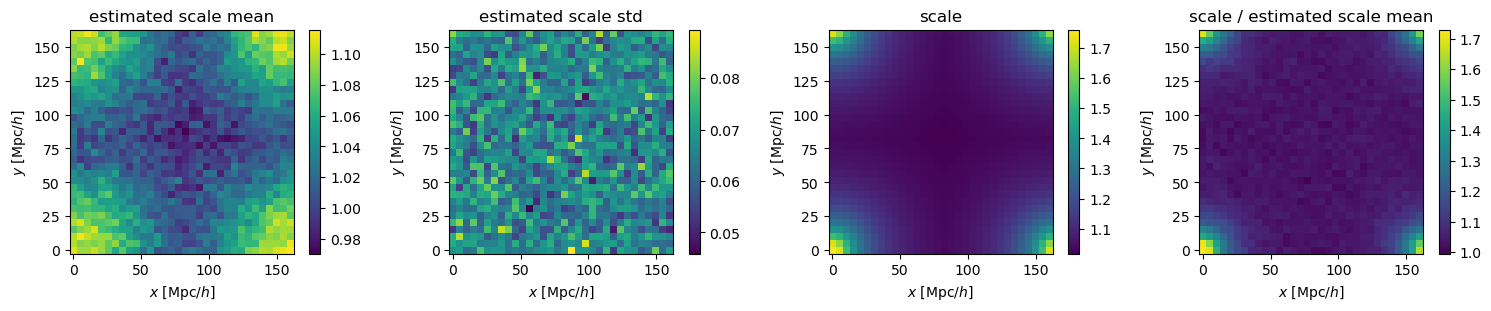

In [5]:
from montecosmo.plot import plot_mesh
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
cosmo = Planck18()
scale, transfer = model._precond_scale_and_transfer(cosmo)
scale = rg2cgh(scale, amp=True)
sli = None

plt.figure(figsize=(15, 3), layout='constrained')

est_scale = vmap(partial(rg2cgh, amp=True))(sqrt_diag_cov['init_mesh_'])
est_scale_mean, est_scale_std = est_scale.mean(0), est_scale.std(0)
plt.subplot(141)
plot_mesh(est_scale_mean, model.box_shape, sli=sli)
plt.title('estimated scale mean')
plt.colorbar()

plt.subplot(142)
plot_mesh(est_scale_std, model.box_shape, sli=sli)
plt.title('estimated scale std')
plt.colorbar()

plt.subplot(143)
plot_mesh(scale, model.box_shape, sli=sli)
plt.title('scale')
plt.colorbar()

plt.subplot(144)
plot_mesh(scale / est_scale_mean, model.box_shape, sli=sli)
plt.title('scale / estimated scale mean')
plt.colorbar()

In [6]:
from tqdm import tqdm
if mcmc_config['sampler'] in ['NUTS', 'HMC']:
    mcmc = get_mcmc(model.model, mcmc_config)
    if continue_run:
        print(f"{jnp.result_type(True)=}") # HACK: why is it working?!!
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 3 ###############
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=44, extra_fields=['num_steps'])

    else:
        mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)

elif mcmc_config['sampler'] == 'NUTSWG':
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    # warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    # state = jit(vmap(init_state_fn))(init_params_)

    # samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    # print("conf:", conf,
    #         "\n\ninfos:", infos, '\n#################\n')
    # jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    # pdump(state, save_path+f"_last_state.p")
    # pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    conf = pload(save_path+'_conf.p')
    state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, n_samples, progress_bar=False)))
    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, end+1)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")

elif mcmc_config['sampler'] == 'MCLMC':
    from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
    from jax.flatten_util import ravel_pytree

    config = None
    # config = {'L':193, 'step_size': 45,} # 64^3
    # config = {'L':500, 'step_size': 10,} # 64^3 norsdb
    # config = {'L':350, 'step_size': 3,} # 64^3 a=.5
    if mcmc_config['mm']:
        sdc = ravel_pytree(tree.map(lambda x:x.mean(0), sqrt_diag_cov))[0]
    else:
        sdc = 1.
    config = {'L':700, 'step_size':35, 'sqrt_diag_cov':sdc} # 64, 128^3 a=.5

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_samples=4096, config=config)))
    state, config = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), init_params_)
    print(config)
    pdump(state, save_path+f"_last_state.p")
    pdump(config, save_path+f"_conf.p")

    # state = pload(save_path+f"_last_state.p")
    # config = pload(save_path+f"_conf.p")
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    thinning = 64
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))

    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, n_runs + start)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples, info = run_fn(jr.split(run_key, n_chains), state, config)
        
        info = tree.map(lambda x: jnp.mean(x**2, 1), info)
        mse_per_dim = {'mse_per_dim': info.energy_change / model.mesh_shape.astype(float).prod()}
        print(info, "\nmean square energy fluctation per dim:", mse_per_dim, '\n')
        pdump(info, save_path+f"_info.p")

        jnp.savez(save_path+f"_{i_run}.npz", **samples)
        pdump(state, save_path+f"_last_state.p")

MCLMCAdaptationState(L=Array([700, 700, 700, 700], dtype=int64, weak_type=True), step_size=Array([35, 35, 35, 35], dtype=int64, weak_type=True), sqrt_diag_cov=Array([1., 1., 1., 1.], dtype=float64, weak_type=True))


  0%|          | 0/15 [00:00<?, ?it/s]

run 1/15


  7%|▋         | 1/15 [05:55<1:22:50, 355.01s/it]

MCLMCInfo(logdensity=Array([1.68394150e+10, 1.68395627e+10, 1.68413467e+10, 1.68391607e+10],      dtype=float64), kinetic_change=Array([1391.51081219, 1108.56273644, 1287.66946366, 1111.93373498],      dtype=float64), energy_change=Array([9.25374722, 2.29174881, 5.74984543, 2.39977698], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([2.82401954e-04, 6.99386232e-05, 1.75471357e-04, 7.32353813e-05],      dtype=float64)} 

run 2/15


 13%|█▎        | 2/15 [10:15<1:04:53, 299.52s/it]

MCLMCInfo(logdensity=Array([1.68384957e+10, 1.68433019e+10, 1.68385905e+10, 1.68403102e+10],      dtype=float64), kinetic_change=Array([1269.8279364 , 1271.17699525, 1166.27344328, 1061.44840322],      dtype=float64), energy_change=Array([ 2.64968527,  4.15091705, 22.10351095,  5.03275197], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([8.08619773e-05, 1.26675935e-04, 6.74545622e-04, 1.53587401e-04],      dtype=float64)} 

run 3/15


 20%|██        | 3/15 [14:35<56:16, 281.38s/it]  

MCLMCInfo(logdensity=Array([1.68396112e+10, 1.68402749e+10, 1.68384843e+10, 1.68373816e+10],      dtype=float64), kinetic_change=Array([1095.8933751 , 1276.40853778, 1339.95344754, 1364.45385436],      dtype=float64), energy_change=Array([ 6.59204078, 25.91119836, 19.95344579, 13.5493341 ], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00020117, 0.00079075, 0.00060893, 0.00041349], dtype=float64)} 

run 4/15


 27%|██▋       | 4/15 [18:56<50:05, 273.21s/it]

MCLMCInfo(logdensity=Array([1.68403826e+10, 1.68420114e+10, 1.68400439e+10, 1.68403094e+10],      dtype=float64), kinetic_change=Array([1216.46122932, 1372.47118103, 1150.32485923, 1450.72599283],      dtype=float64), energy_change=Array([46.15758705, 11.90674193,  3.55770699, 40.80694459], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00140862, 0.00036336, 0.00010857, 0.00124533], dtype=float64)} 

run 5/15


 33%|███▎      | 5/15 [23:15<44:43, 268.37s/it]

MCLMCInfo(logdensity=Array([1.68419332e+10, 1.68424430e+10, 1.68382713e+10, 1.68393864e+10],      dtype=float64), kinetic_change=Array([1232.02233647, 1152.71082706, 1148.41494555, 1026.31370703],      dtype=float64), energy_change=Array([ 6.66675692, 24.49723748, 25.27939636,  5.34115914], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00020345, 0.0007476 , 0.00077147, 0.000163  ], dtype=float64)} 

run 6/15


 40%|████      | 6/15 [27:36<39:51, 265.75s/it]

MCLMCInfo(logdensity=Array([1.68406437e+10, 1.68416012e+10, 1.68393926e+10, 1.68397322e+10],      dtype=float64), kinetic_change=Array([1058.19883274, 1138.54365253, 1182.90464867, 1272.17569055],      dtype=float64), energy_change=Array([ 3.11597639,  4.89829947,  4.5016942 , 11.83898317], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([9.50920528e-05, 1.49484237e-04, 1.37380804e-04, 3.61297094e-04],      dtype=float64)} 

run 7/15


 47%|████▋     | 7/15 [31:56<35:10, 263.79s/it]

MCLMCInfo(logdensity=Array([1.68385185e+10, 1.68372696e+10, 1.68388019e+10, 1.68404063e+10],      dtype=float64), kinetic_change=Array([1156.64274513, 1252.6032111 , 1180.39811177, 1205.56271702],      dtype=float64), energy_change=Array([7.43612589, 9.60144282, 3.87710849, 1.7063338 ], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([2.26932553e-04, 2.93012781e-04, 1.18319961e-04, 5.20731749e-05],      dtype=float64)} 

run 8/15


 53%|█████▎    | 8/15 [36:17<30:39, 262.81s/it]

MCLMCInfo(logdensity=Array([1.68436289e+10, 1.68388749e+10, 1.68390498e+10, 1.68370213e+10],      dtype=float64), kinetic_change=Array([1324.41048593, 1095.37733766, 1245.86133544, 1295.4971492 ],      dtype=float64), energy_change=Array([ 9.49373208,  4.85581558,  6.83581236, 18.0225963 ], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00028973, 0.00014819, 0.00020861, 0.00055001], dtype=float64)} 

run 9/15


 60%|██████    | 9/15 [40:36<26:11, 261.86s/it]

MCLMCInfo(logdensity=Array([1.68409673e+10, 1.68380272e+10, 1.68409342e+10, 1.68397193e+10],      dtype=float64), kinetic_change=Array([1307.22746387, 1411.61560716, 1316.89875039, 1435.35320508],      dtype=float64), energy_change=Array([ 4.99219482, 47.32570162,  9.03519664, 54.42355934], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00015235, 0.00144427, 0.00027573, 0.00166088], dtype=float64)} 

run 10/15


 67%|██████▋   | 10/15 [44:57<21:47, 261.50s/it]

MCLMCInfo(logdensity=Array([1.68375286e+10, 1.68401618e+10, 1.68391001e+10, 1.68374604e+10],      dtype=float64), kinetic_change=Array([1338.24417838, 1086.13469809, 1221.40576068, 1192.51746958],      dtype=float64), energy_change=Array([11.09559962,  4.77519941,  3.50050338, 29.84302759], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00033861, 0.00014573, 0.00010683, 0.00091074], dtype=float64)} 

run 11/15


 73%|███████▎  | 11/15 [49:17<17:23, 260.98s/it]

MCLMCInfo(logdensity=Array([1.68378383e+10, 1.68415192e+10, 1.68399888e+10, 1.68401922e+10],      dtype=float64), kinetic_change=Array([1298.63697314, 1597.73247948, 1363.19977552, 1189.56738106],      dtype=float64), energy_change=Array([ 14.91327293, 306.12312344,   2.60794702,   4.64795604], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([4.55116972e-04, 9.34213634e-03, 7.95882269e-05, 1.41844362e-04],      dtype=float64)} 

run 12/15


 80%|████████  | 12/15 [53:38<13:02, 260.89s/it]

MCLMCInfo(logdensity=Array([1.68388884e+10, 1.68393869e+10, 1.68368738e+10, 1.68396758e+10],      dtype=float64), kinetic_change=Array([1522.30322268, 1206.20912127, 1371.23592867, 1266.49532   ],      dtype=float64), energy_change=Array([45.99127414, 11.09888188,  7.89506087,  2.57056733], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([1.40354230e-03, 3.38710995e-04, 2.40938137e-04, 7.84474892e-05],      dtype=float64)} 

run 13/15


 87%|████████▋ | 13/15 [57:57<08:41, 260.55s/it]

MCLMCInfo(logdensity=Array([1.68412809e+10, 1.68409194e+10, 1.68412407e+10, 1.68400139e+10],      dtype=float64), kinetic_change=Array([1227.15408298, 1158.03445344, 1382.38536685, 1111.1071826 ],      dtype=float64), energy_change=Array([ 4.87676904, 11.24966431, 12.64614672, 15.91395215], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00014883, 0.00034331, 0.00038593, 0.00048566], dtype=float64)} 

run 14/15


 93%|█████████▎| 14/15 [1:02:18<04:20, 260.60s/it]

MCLMCInfo(logdensity=Array([1.68346221e+10, 1.68369432e+10, 1.68433034e+10, 1.68377346e+10],      dtype=float64), kinetic_change=Array([1372.575151  , 1356.23844318, 1203.72674682, 1083.46851104],      dtype=float64), energy_change=Array([7.12558088, 4.07610444, 1.90185703, 9.17461298], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([2.17455471e-04, 1.24392836e-04, 5.80400706e-05, 2.79986968e-04],      dtype=float64)} 

run 15/15


100%|██████████| 15/15 [1:06:38<00:00, 266.55s/it]

MCLMCInfo(logdensity=Array([1.68379209e+10, 1.68419763e+10, 1.68390234e+10, 1.68390096e+10],      dtype=float64), kinetic_change=Array([1331.95796665, 1215.36271165, 1217.15556231, 1090.48746238],      dtype=float64), energy_change=Array([16.19750839, 14.93062579,  5.93193526,  7.30144685], dtype=float64)) 
mean square energy fluctation per dim: {'mse_per_dim': Array([0.00049431, 0.00045565, 0.00018103, 0.00022282], dtype=float64)} 



In [ ]:
pdump(info, save_path+f"_info.p")
!scancel 5281377

In [5]:
1/5 * 2e2 * 40

1600.0